In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm

from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.models as models

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [4]:
train_len = int(0.8 * len(training_data))
val_len = len(training_data) - train_len
torch.manual_seed(42)
train_data, val_data = random_split(training_data, [train_len, val_len])

In [5]:
len(train_data), len(val_data), len(test_data)

(48000, 12000, 10000)

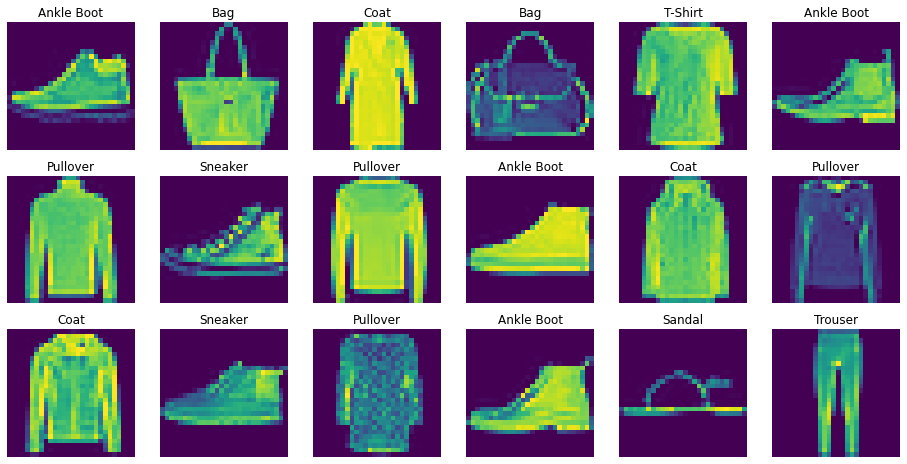

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

In [7]:
training_data[0][0].shape, training_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


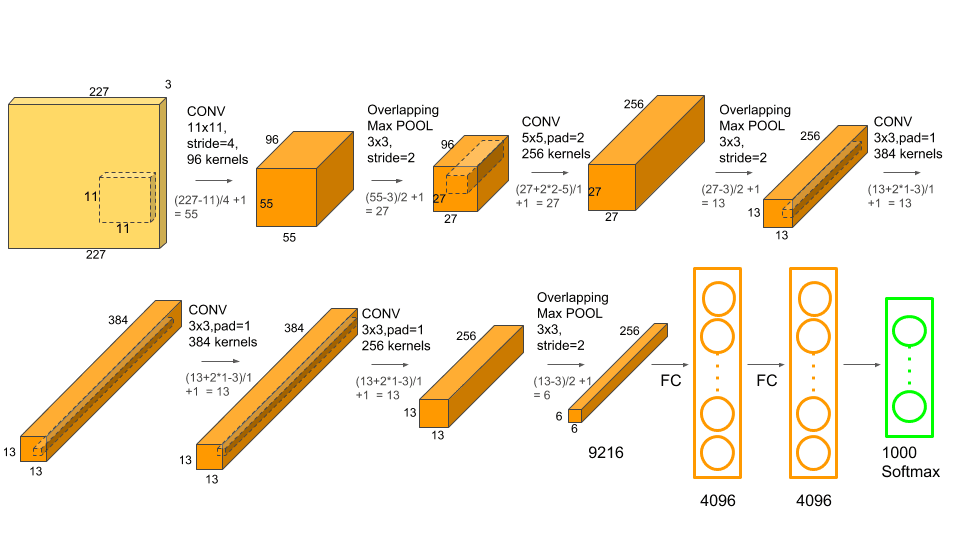

In [10]:
class Model(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(Model, self).__init__()

        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs



In [11]:
model = Model(num_classes=len(labels_map))
model = model.to(device)

In [12]:
model

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for batch, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred, probs = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred, probs = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    return correct, test_loss

In [16]:
epochs = 20
train_acc = []
train_losses = []
test_acc = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    train_correct, train_loss = test(train_dataloader, model, loss_fn)
    train_acc.append(train_correct)
    train_losses.append(train_loss)
    print(f"Train Error: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    test_correct, test_loss = test(test_dataloader, model, loss_fn)
    test_acc.append(test_correct)
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # torch.save(model.state_dict(), f"models/model{t}.pth")

print("Done!")

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 165.89it/s]


Train Error: 
 Accuracy: 79.6%, Avg loss: 0.534676 



100%|██████████| 157/157 [00:00<00:00, 163.76it/s]


Test Error: 
 Accuracy: 78.6%, Avg loss: 0.567008 

Epoch 2
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 167.60it/s]


Train Error: 
 Accuracy: 82.9%, Avg loss: 0.453910 



100%|██████████| 157/157 [00:00<00:00, 163.94it/s]


Test Error: 
 Accuracy: 81.9%, Avg loss: 0.487593 

Epoch 3
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 167.22it/s]


Train Error: 
 Accuracy: 84.6%, Avg loss: 0.411150 



100%|██████████| 157/157 [00:00<00:00, 164.95it/s]


Test Error: 
 Accuracy: 83.1%, Avg loss: 0.448489 

Epoch 4
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 166.47it/s]


Train Error: 
 Accuracy: 85.7%, Avg loss: 0.379737 



100%|██████████| 157/157 [00:00<00:00, 167.22it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.421640 

Epoch 5
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 165.04it/s]


Train Error: 
 Accuracy: 86.7%, Avg loss: 0.354605 



100%|██████████| 157/157 [00:00<00:00, 169.13it/s]


Test Error: 
 Accuracy: 84.8%, Avg loss: 0.401091 

Epoch 6
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 166.86it/s]


Train Error: 
 Accuracy: 87.3%, Avg loss: 0.335406 



100%|██████████| 157/157 [00:00<00:00, 163.96it/s]


Test Error: 
 Accuracy: 85.3%, Avg loss: 0.385990 

Epoch 7
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 164.81it/s]


Train Error: 
 Accuracy: 87.9%, Avg loss: 0.320154 



100%|██████████| 157/157 [00:00<00:00, 162.46it/s]


Test Error: 
 Accuracy: 85.7%, Avg loss: 0.375225 

Epoch 8
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.21it/s]


Train Error: 
 Accuracy: 88.3%, Avg loss: 0.308118 



100%|██████████| 157/157 [00:00<00:00, 160.17it/s]


Test Error: 
 Accuracy: 86.0%, Avg loss: 0.368127 

Epoch 9
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.79it/s]


Train Error: 
 Accuracy: 88.7%, Avg loss: 0.298455 



100%|██████████| 157/157 [00:00<00:00, 162.66it/s]


Test Error: 
 Accuracy: 86.2%, Avg loss: 0.363720 

Epoch 10
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.75it/s]


Train Error: 
 Accuracy: 89.0%, Avg loss: 0.290179 



100%|██████████| 157/157 [00:00<00:00, 159.97it/s]


Test Error: 
 Accuracy: 86.4%, Avg loss: 0.360708 

Epoch 11
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.43it/s]


Train Error: 
 Accuracy: 89.3%, Avg loss: 0.282898 



100%|██████████| 157/157 [00:00<00:00, 162.42it/s]


Test Error: 
 Accuracy: 86.5%, Avg loss: 0.359159 

Epoch 12
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 162.66it/s]


Train Error: 
 Accuracy: 89.6%, Avg loss: 0.276657 



100%|██████████| 157/157 [00:00<00:00, 164.38it/s]


Test Error: 
 Accuracy: 86.7%, Avg loss: 0.357832 

Epoch 13
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 162.30it/s]


Train Error: 
 Accuracy: 89.8%, Avg loss: 0.271662 



100%|██████████| 157/157 [00:00<00:00, 161.98it/s]


Test Error: 
 Accuracy: 86.7%, Avg loss: 0.357293 

Epoch 14
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.72it/s]


Train Error: 
 Accuracy: 90.0%, Avg loss: 0.266891 



100%|██████████| 157/157 [00:00<00:00, 162.01it/s]


Test Error: 
 Accuracy: 86.7%, Avg loss: 0.356735 

Epoch 15
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 161.87it/s]


Train Error: 
 Accuracy: 90.2%, Avg loss: 0.262251 



100%|██████████| 157/157 [00:00<00:00, 163.72it/s]


Test Error: 
 Accuracy: 86.9%, Avg loss: 0.355779 

Epoch 16
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 164.84it/s]


Train Error: 
 Accuracy: 90.3%, Avg loss: 0.257908 



100%|██████████| 157/157 [00:00<00:00, 163.57it/s]


Test Error: 
 Accuracy: 87.0%, Avg loss: 0.354790 

Epoch 17
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 161.31it/s]


Train Error: 
 Accuracy: 90.4%, Avg loss: 0.254551 



100%|██████████| 157/157 [00:00<00:00, 159.39it/s]


Test Error: 
 Accuracy: 87.1%, Avg loss: 0.354689 

Epoch 18
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.61it/s]


Train Error: 
 Accuracy: 90.6%, Avg loss: 0.250199 



100%|██████████| 157/157 [00:00<00:00, 161.60it/s]


Test Error: 
 Accuracy: 87.4%, Avg loss: 0.355164 

Epoch 19
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.85it/s]


Train Error: 
 Accuracy: 90.7%, Avg loss: 0.245425 



100%|██████████| 157/157 [00:00<00:00, 164.26it/s]


Test Error: 
 Accuracy: 87.4%, Avg loss: 0.355708 

Epoch 20
-------------------------------


100%|██████████| 938/938 [00:05<00:00, 163.84it/s]


Train Error: 
 Accuracy: 90.9%, Avg loss: 0.240249 



100%|██████████| 157/157 [00:00<00:00, 161.93it/s]

Test Error: 
 Accuracy: 87.4%, Avg loss: 0.356506 

Done!


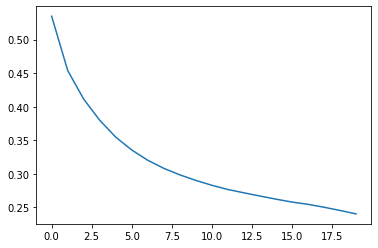

In [17]:
plt.plot(train_losses)

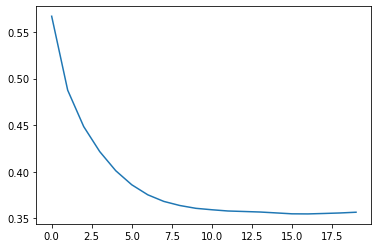

In [18]:
plt.plot(test_losses)

In [19]:
class SiameseDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        img1, label1 = random.choice(self.dataset)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 == label2:
                    break
        else:
            while True:
                #Look untill a different class image is found
                img2, label2 = random.choice(self.dataset) 
                if label1 != label2:
                    break
        
        return img1, img2, torch.from_numpy(np.array([int(label1 != label2)], dtype=np.float32))
    
    def __len__(self):
        return len(self.dataset)

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(240, 80),
            nn.BatchNorm1d(80),
            nn.ReLU(),
            nn.Linear(80, 30),
            nn.BatchNorm1d(30),
            nn.ReLU(),
            nn.Linear(30, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, input1, input2):
        combined_features = torch.cat([input1, input2], dim=1)
        # combined_features = input1 * input2

        return self.fc(combined_features)

In [21]:
siamese = SiameseNetwork()
siamese = siamese.to(device)

siamese_criterion = torch.nn.BCELoss()
siamese_optimizer = torch.optim.Adam(siamese.parameters(), lr = 0.001)

In [22]:
train_datas = SiameseDataset(train_data)
val_datas = SiameseDataset(val_data)
test_datas = SiameseDataset(test_data)

siam_test_dataloader = DataLoader(test_datas, batch_size=batch_size)

In [23]:
import copy

feature_model = copy.deepcopy(model)
feature_model.classifier = nn.Identity()
feature_model.eval()

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Identity()
)

In [24]:
loss_history = []
correct_history = []

# Iterate throught the epochs
for epoch in tqdm(range(20)):

    total_loss, correct = 0, 0
    
    # Iterate over batches
    for img0, img1, label in siam_test_dataloader:
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        img0, probs0 = feature_model(img0)
        img1, probs1 = feature_model(img1)

        prob = siamese(img0, img1)
        loss = siamese_criterion(prob, label)

        siamese_optimizer.zero_grad()
        loss.backward()
        siamese_optimizer.step()

        total_loss += loss.item()
        correct += torch.count_nonzero(label == (prob > 0.9)).item()

    print("Loss, Correct", total_loss, correct)
        
    loss_history.append(total_loss)
    correct_history.append(correct)

  5%|▌         | 1/20 [00:06<01:57,  6.20s/it]

Loss, Correct 69.19227772951126 6225


 10%|█         | 2/20 [00:12<01:48,  6.00s/it]

Loss, Correct 47.43239887058735 7695


 15%|█▌        | 3/20 [00:18<01:42,  6.05s/it]

Loss, Correct 42.8529109954834 8137


 20%|██        | 4/20 [00:24<01:36,  6.04s/it]

Loss, Correct 41.27043406665325 8233


 25%|██▌       | 5/20 [00:30<01:30,  6.04s/it]

Loss, Correct 40.04054541885853 8320


 30%|███       | 6/20 [00:36<01:24,  6.02s/it]

Loss, Correct 38.403120934963226 8402


 35%|███▌      | 7/20 [00:42<01:17,  5.96s/it]

Loss, Correct 37.79893098771572 8390


 40%|████      | 8/20 [00:48<01:12,  6.01s/it]

Loss, Correct 36.283070273697376 8514


 45%|████▌     | 9/20 [00:54<01:06,  6.00s/it]

Loss, Correct 36.93824850767851 8454


 50%|█████     | 10/20 [01:00<01:00,  6.01s/it]

Loss, Correct 36.478807628154755 8501


 55%|█████▌    | 11/20 [01:06<00:54,  6.00s/it]

Loss, Correct 35.291648022830486 8586


 60%|██████    | 12/20 [01:12<00:47,  5.99s/it]

Loss, Correct 35.06561905145645 8558


 65%|██████▌   | 13/20 [01:18<00:42,  6.03s/it]

Loss, Correct 34.74239090830088 8588


 70%|███████   | 14/20 [01:24<00:36,  6.02s/it]

Loss, Correct 33.46302308887243 8623


 75%|███████▌  | 15/20 [01:30<00:30,  6.03s/it]

Loss, Correct 33.89206950366497 8685


 80%|████████  | 16/20 [01:36<00:24,  6.02s/it]

Loss, Correct 33.99945655465126 8601


 85%|████████▌ | 17/20 [01:42<00:18,  6.01s/it]

Loss, Correct 33.50590718537569 8705


 90%|█████████ | 18/20 [01:48<00:12,  6.01s/it]

Loss, Correct 33.90255515277386 8659


 95%|█████████▌| 19/20 [01:54<00:06,  6.03s/it]

Loss, Correct 32.97263265401125 8654


100%|██████████| 20/20 [02:00<00:00,  6.02s/it]

Loss, Correct 33.13705646246672 8654


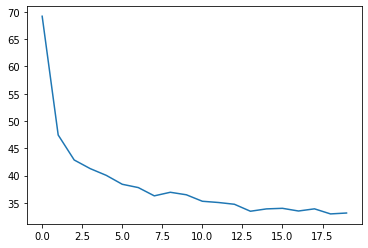

In [25]:
plt.plot(loss_history)

In [26]:
siamese.eval()

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=240, out_features=80, bias=True)
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=80, out_features=30, bias=True)
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [27]:
img0 = test_data[1][0]
img1 = test_data[1][0]

img0 = img0.unsqueeze(1)
img1 = img1.unsqueeze(1)

img0 = img0.to(device)
img1 = img1.to(device)

img0, probs0 = feature_model(img0)
img1, probs1 = feature_model(img1)

print(img0.shape, img1.shape)

siamese(img0, img1)[0].item(), test_data[1][1], test_data[1][1]

torch.Size([1, 120]) torch.Size([1, 120])


(0.044285330921411514, 2, 2)

In [28]:
def find_similar(img0, dataset):
    res = []
    
    img0 = img0.unsqueeze(1)
    img0 = img0.to(device)
    img0, probs0 = feature_model(img0)
    
    for i in tqdm(range(len(dataset))):
        img1 = dataset[i][0]
        img1 = img1.unsqueeze(1)
        img1 = img1.to(device)
        img1, probs1 = feature_model(img1)
        
        res.append(siamese(img0, img1)[0].item())
        
    return res

In [29]:
indices = torch.arange(0, 1000)
test_data_sub = data_utils.Subset(test_data, indices)

similar = find_similar(test_data[1][0], test_data_sub)

100%|██████████| 1000/1000 [00:01<00:00, 928.59it/s]


In [30]:
sorted_similar = np.argsort(similar)

In [31]:
most_similar_5 = sorted_similar[:5]

print("Most similar:", most_similar_5)

Most similar: [969 161 804 497 911]


In [32]:
print("Classes of most similar:", [labels_map[test_data_sub[i][1]] for i in most_similar_5])

Classes of most similar: ['Pullover', 'Pullover', 'Pullover', 'Pullover', 'Pullover']


In [33]:
least_similar_5 = sorted_similar[-5:]

print("Least similar:", least_similar_5)

Least similar: [722 925 333 189 972]


In [34]:
print("Classes of least similar:", [labels_map[test_data_sub[i][1]] for i in least_similar_5])

Classes of least similar: ['Sandal', 'Sneaker', 'Sneaker', 'Sneaker', 'Sneaker']


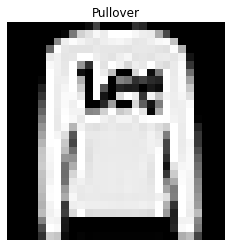

In [35]:
plt.imshow(test_data[1][0].squeeze(), cmap="gray")
plt.title(labels_map[test_data[1][1]])
plt.axis("off")
plt.show()

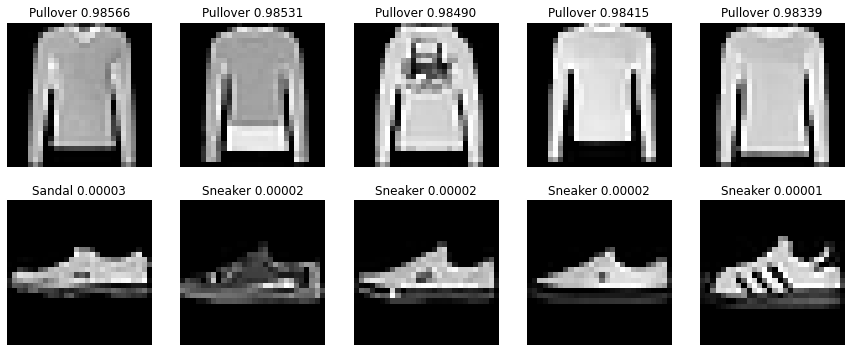

In [36]:
figure = plt.figure(figsize=(15, 6))
cols, rows = 5, 2

for i in range(1, cols * rows + 1):
    if i < 6:
        sample_idx = most_similar_5[i - 1]
    else:
        sample_idx = least_similar_5[i - 6]
        
    img, label = test_data_sub[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'{labels_map[label]} {1.0 - similar[sample_idx]:.5f}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [37]:
def all_preds(dataloader):
    res = []

    for X, y in tqdm(dataloader):
        X = X.to(device)
        pred, prob = model(X)
        pred = pred.detach().cpu()

        for i in range(len(y)):
            res.append((pred[i].numpy(), y[i].numpy()))
    
    return res

In [38]:
features = [p[0] for p in all_preds(test_dataloader)]
labels = [p[1] for p in all_preds(test_dataloader)]

100%|██████████| 157/157 [00:01<00:00, 138.87it/s]


In [39]:
tsne = TSNE(n_components=2, init='pca', random_state=42, method='barnes_hut', n_iter=500, verbose=2)
tsne_features = tsne.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 0.578s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.290817
[t-SNE] Computed conditional probabilities in 0.393s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 70.8637085, gradient norm = 0.0031874 (50 iterations in 3.463s)
[t-SNE] Iteration 100: error = 71.5202255, gradient norm = 0.0020087 (50 iterations in 3.307s)
[t-SNE] Iteration 150: error = 71.4694366, gradient norm = 0.0021034 (50 iterations in 3.246s)
[t-SNE] Iteration 200: error = 71.9372253, gradient norm = 0.0007751 (50 iterations in 3.221s)
[t-SNE] Iteration 250: error = 72.0467072, gradient norm = 0.0006827 (50 iterations in 3.226s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.046707
[t-SNE] Iteration 300: error = 2.3022385, gradient norm = 0.0011033 (50 iterations in 3.372s)
[t-SNE] Iteration 350: error = 1.9993311, gradient norm = 0.0004966 (50 iterations in 3.505s)
[t-SNE] Iteration 400: error = 1.8459988, gradient norm = 0.0003234 (50 iterations in 3.449s)
[t-SNE] Iteration 450: error = 1.7374213, gradient norm = 0.0002329 (50 iterations in 3.345s)
[t-SNE] Iteration 500: error = 1.6553711, gradient norm = 0.0001796 (50 

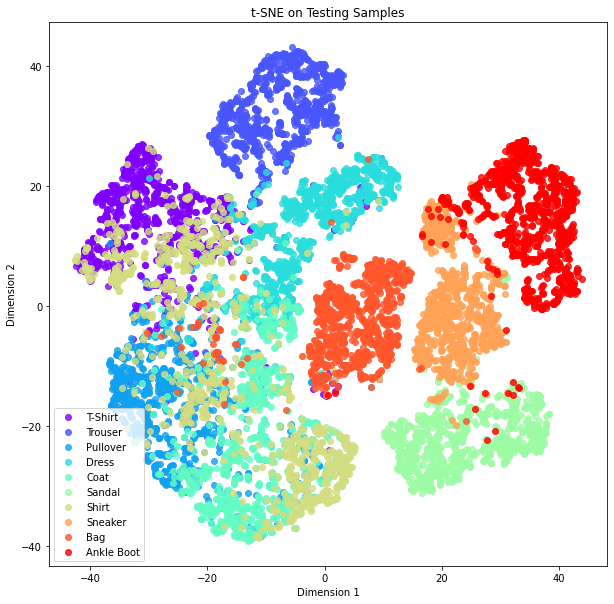

In [40]:
obj_categories = list(labels_map.values())
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(np.array(labels) == c_group), 0], tsne_features[np.where(np.array(labels) == c_group), 1], 
                marker='o', color=c_color, linewidth=1, alpha=0.8, label=c_label)
    
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)